# AdventureWorks Försäljningsanalys
Vi undersöker AdventureWorks data för att besvara affärsfrågor.

- Produktkategorier och försäljning
- Trender
- Segment

Vi använder SQL för att hämta data och Python för visualisering och analys

In [33]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus


user = "SA"
password = quote_plus("TimAjenR!1")
server = "localhost:1433"
database = "AdventureWorks2025"
driver = quote_plus("ODBC Driver 18 for SQL Server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\timry\AppData\Local\Temp\ipykernel_142144\4029154932.py:24: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [17]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql),conn)

## Visualisering 1: Antal produkter per kategori
Affärsfråga: Hur många produkter finns i varje kategori?

Använda tabeller: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
- JOINA tabellerna
- Räkna DISTINCT produkter per kategori
- Skapa vertikalt stapeldiagram
- Analysera resultat

"• Räkna unika produkter per kategori

Krav på visualisering:
• Typ: Vertikalt stapeldiagram (bar)
• Titel: "Antal produkter per kategori"
Krav på insikt:
• Förklara vilken kategori som har flest/minst produkter."

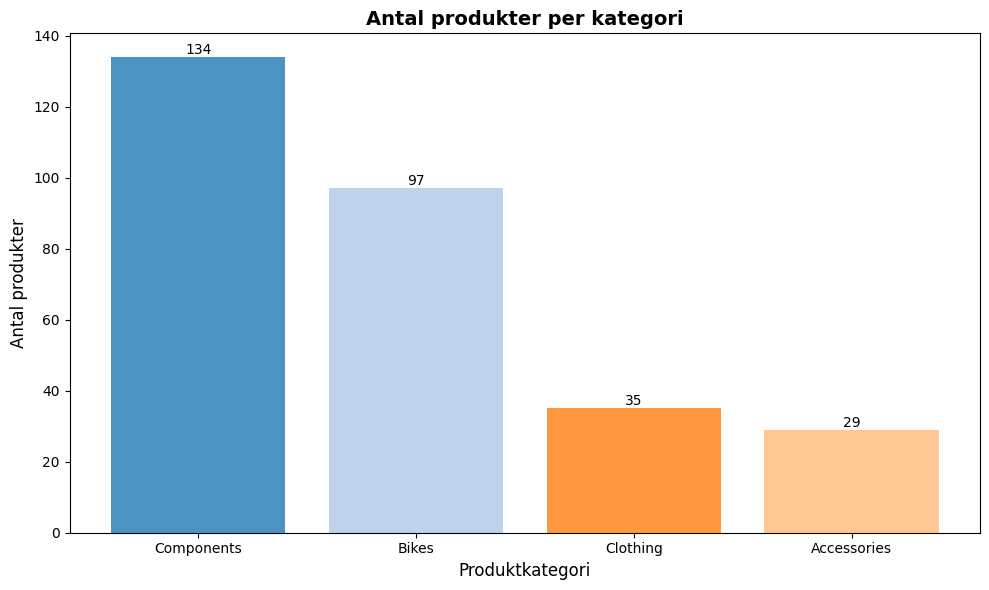

In [18]:
query_vis1 = """

SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC

"""

df_vis1 = query_df(query_vis1)

#Färger
colors = plt.cm.tab20(range(len(df_vis1)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'],color = colors, alpha = 0.8)

#Siffror
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f'{int(height)}',
        ha = 'center',
        va = 'bottom'
    )

# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### Insikter - Antal produkter per kategori
Components har flest produkter på 134 st
Acccessories är minst med 29 produkter.

Slutsats:  
Företaget har en stor del komponenter och reservdelar. Troligtvis för att stötta deras näst största grupp som är cyklar.
Deras minsta diversifierade produktgrupp är accessories , kan vara ett segment som kan utvecklas.

# Visualisering 2: Försäljning per produktkategori
## Affärsfråga: Vilka produktkategorier genererar mest intäkter?
Använda tabeller: 
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product
- Sales.SalesOrderDetail

Uppgift:  

• Sortera från högst till lägst försäljning  
Krav på visualisering:  
• Typ: Horisontellt stapeldiagram (barh)  
• Titel: "Total försäljning per produktkategori"  
• Sortera staplar från högst till lägst (högsta överst)  
Krav på insikt:  
• Förklara vilken kategori som är störst och minst, med exakta siffror.  

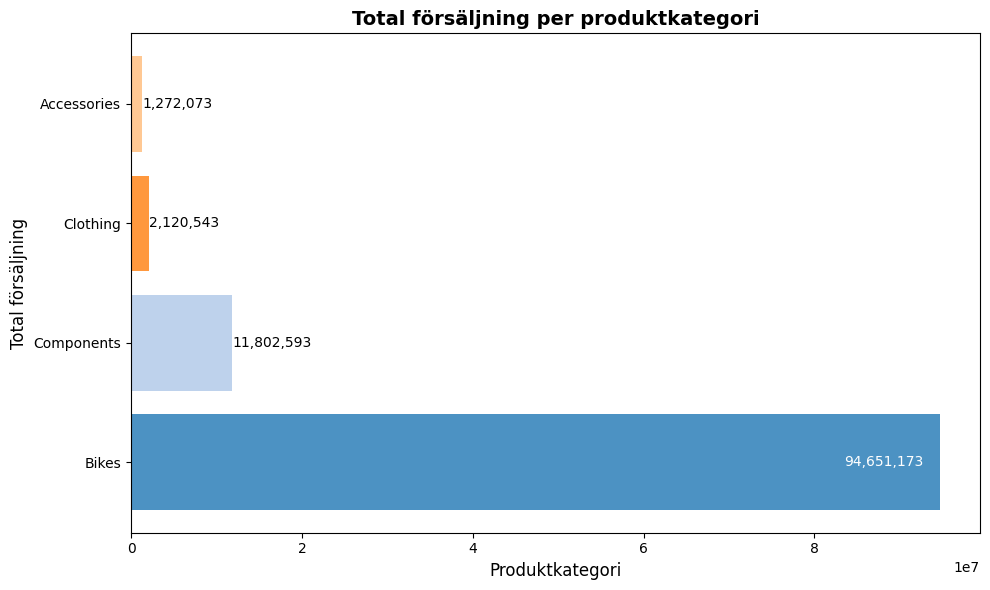

In [ ]:
query_vis2 = """
SELECT
    pc.Name AS CategoryName,
    SUM(sod.LineTotal) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""
df_vis2 = query_df(query_vis2)
#Färger
colors = plt.cm.tab20(range(len(df_vis2)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis2['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.15 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Total försäljning per produktkategori', fontsize = 14, fontweight = 'bold')

#Visa plot
plt.tight_layout()
plt.show()


### Insikter - Försäljning per produktkategori

Majoriteten av försäljningen kommer från Bikes. På en total summa på 94.651.172 SEK vilket är ca 86,2% av den totala försäljningen. Accessories står bara för 1,2% på en total av 1.272.072 SEK

# Visualisering 3: Försäljningstrend över tid
## Affärsfråga: Hur har försäljningen utvecklats över tid?

Använda tabeller: 
- Sales.SalesOrderHeader   
Uppgift

• Aggregera per månad (minst 12 månader data)
• Sortera kronologiskt (äldst först)
Krav på visualisering:
• Typ: Linjediagram (line plot)
• Titel: "Försäljningstrend per månad"
• Visa tydlig tidslinje på X-axeln
Krav på insikt:
• Beskriv trenden - ökar den, minskar den, är den säsongsberoende? Nämn högsta och lägsta månaden.

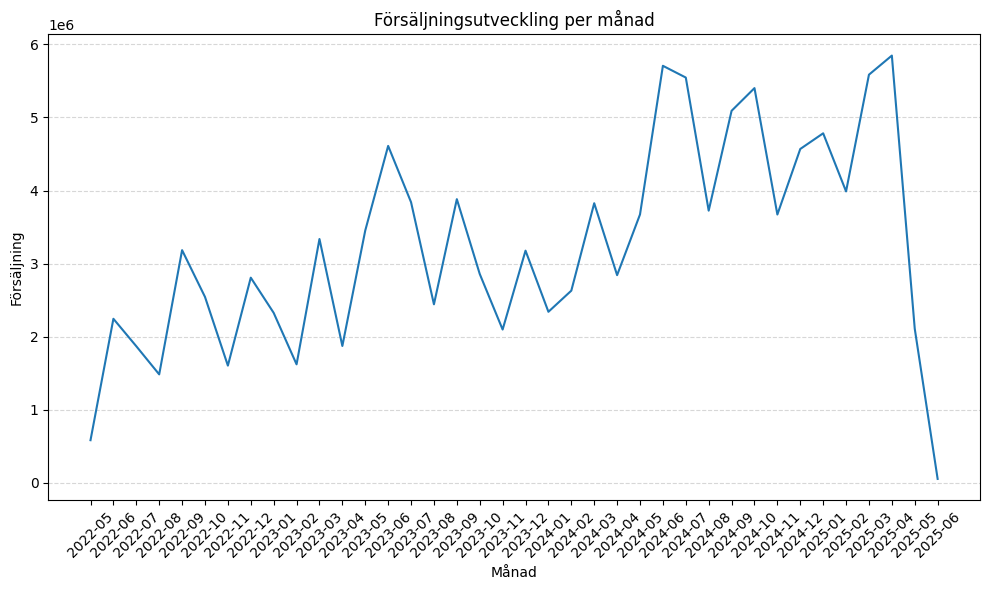

In [ ]:
query_vis3 = """
SELECT
    FORMAT(OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(TotalDue) AS SalesAmount
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY OrderMonth;
"""

df_vis3 = query_df(query_vis3)

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(df_vis3['OrderMonth'],df_vis3['SalesAmount'])

ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# Etiketter och titel
ax.set_title("Försäljningsutveckling per månad")
ax.set_xlabel("Månad")
ax.set_ylabel("Försäljning")



# Rotera x-axelns etiketter för bättre läsbarhet
plt.xticks(rotation=45)

# Visa diagrammet
plt.tight_layout()
plt.show()





### Insikter - Försäljning över tid
Försäljningen har generellt ökat över perioden 2022–2025, med tydliga säsongsvariationer. Den högsta månaden var april 2025, medan den lägsta var maj 2022. Mönstret tyder på att försäljningen ofta är högre under vår och sommar och lägre under vintermånaderna.

Visualisering 4: Försäljning och antal ordrar per år   
Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?   
Krav på data:   
• Använd tabeller: Sales.SalesOrderHeader   
• Visa både total försäljning OCH antal ordrar   
• Gruppera per år   
• Sortera kronologiskt   
Krav på visualisering:   
• Typ: Grupperat stapeldiagram (grouped bar chart) ELLER två separata staplar per år   
• Titel: "Försäljning och antal ordrar per år"   
Krav på insikt:   
• Jämför åren - vilket år hade högst försäljning? Ökar både försäljning OCH antal ordrar, eller bara det ena?

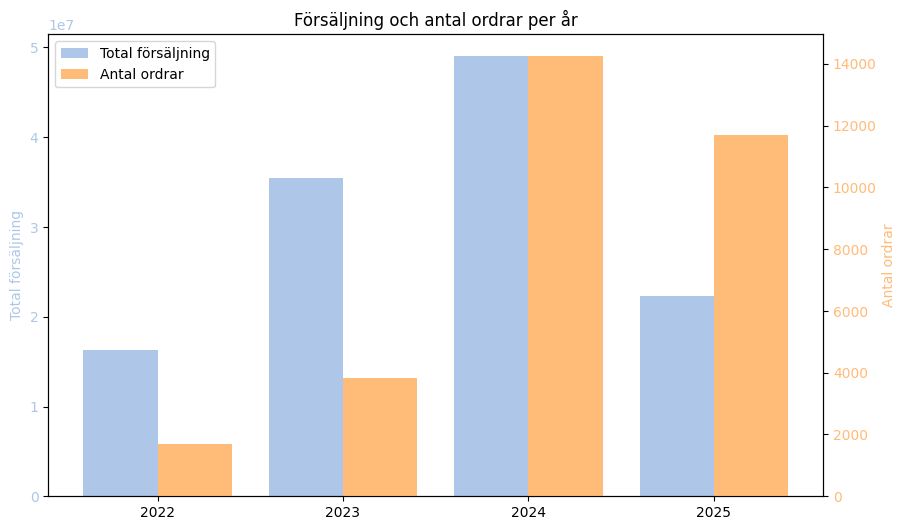

In [43]:
query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    COUNT(SalesOrderID) AS NbrOrders,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY Year;
"""

df_vis4 = query_df(query_vis4)


import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(df_vis4))  # positioner på x-axeln
width = 0.4

fig, ax1 = plt.subplots(figsize=(10,6))

# TotalSales som blå stapel
ax1.bar(x - width/2, df_vis4['TotalSales'], width, color=plt.cm.tab20(1), label='Total försäljning')
ax1.set_ylabel('Total försäljning', color=plt.cm.tab20(1))
ax1.tick_params(axis='y', labelcolor=plt.cm.tab20(1))

# NbrOrders som röd stapel på sekundär y-axel
ax2 = ax1.twinx()
ax2.bar(x + width/2, df_vis4['NbrOrders'], width, color=plt.cm.tab20(3), label='Antal ordrar')
ax2.set_ylabel('Antal ordrar', color=plt.cm.tab20(3))
ax2.tick_params(axis='y', labelcolor=plt.cm.tab20(3))

# X-axel etiketter
ax1.set_xticks(x)
ax1.set_xticklabels(df_vis4['Year'])
plt.title('Försäljning och antal ordrar per år')

# Legend: kombinerar båda
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.show()


### Insikt - Försäljning och antal orders per år

Både försäljning och antal ordrar följer samma trend: ökande från 2022 → 2024, sedan en liten nedgång i antal ordrar 2025 men försäljning sjunker ännu mer.

- 2024 var det starkaste året både i försäljning och antal ordrar – toppår för företaget.

- 2025: även om antal ordrar fortfarande är högt (~12 000), minskar total försäljning kraftigt (~22 miljoner).

Detta tyder på lägre genomsnittligt ordervärde – fler men mindre ordrar. Alternativt så är datan för 2025 felaktig

5: Top 10 produkter   
Affärsfråga: Vilka 10 produkter genererar mest försäljning?   
Krav på data:   
• Använd tabeller: Production.Product, Sales.SalesOrderDetail   
• Visa endast TOP 10 produkter   
• Sortera från högst till lägst försäljning   
Krav på visualisering:  
• Typ: Horisontellt stapeldiagram (barh)   
• Titel: "Top 10 produkter efter försäljning"   
• Sortera staplar från högst till lägst (högsta överst)   
Krav på insikt:   
• Nämn #1 produkten med exakt försäljningsvärde. Vilken kategori dominerar topp 10?   

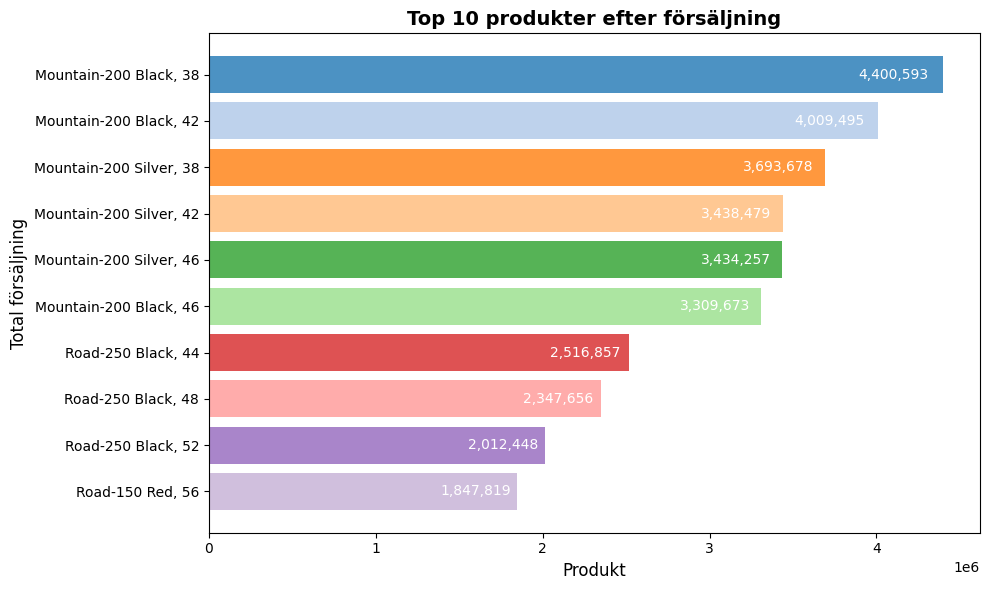

In [48]:
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
INNER JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""
df_vis5 = query_df(query_vis5)
#Färger
colors = plt.cm.tab20(range(len(df_vis5)))

#Plot
fig, ax = plt.subplots(figsize = (10,6))
bars = ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'],color = colors, alpha = 0.8)

#Siffror
max_value = df_vis5['TotalSales'].max()

for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    
    if width > 0.15 * max_value:
        x = width * 0.98
        ha = 'right'
        color = 'white'
    else:
        x = width * 1.01
        ha = 'left'
        color = 'black'

    ax.text(
        x,
        y,
        f'{width:,.0f}',
        va='center',
        ha=ha,
        color=color
    )
# Titlar
ax.set_xlabel('Produkt', fontsize = 12)
ax.set_ylabel('Total försäljning', fontsize = 12)
ax.set_title('Top 10 produkter efter försäljning', fontsize = 14, fontweight = 'bold')

#Visa plot
ax.invert_yaxis()
plt.tight_layout()
plt.show()


### Insikt - Top 10 produkter
Samtliga 10 cyklar är inom kategorin "Bikes" och bästa produkten är "Mountain-200 BLACK,38" med en total försäljning på 4,400,592.800400 SEK